# WaterLLMarks Project using Langchain's API

The goal of the study is to review the use of text watermarks to track users throughout a LLM SaaS platform. The study implements the following pipelines:
- Question Answering without RAG.
- Question Answering with RAG (implemented as a naive RAG using Chroma).
- QA with RAG and a token-based watermark (`waterllmarks.watermarks.TokenWatermark`).
- QA with RAG and a watermark using character-embedding (`waterllmarks.watermarks.Rizzo2016`).
- With and without augmentation -> ideally see the impact of the augemntation on the llm response and/or the retrieved documents

The goal is to assess the response quality of the different pipelines using known metrics:
- BLEU, ROUGE, METEOR
- String similarity (Levenshtein distance)
- Context precision and recall (for RAG)
- Retrieved documents compared to reference.


## Setup dataset and corpus

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.globals import set_llm_cache
from langchain_community.cache import SQLiteCache


# set_llm_cache(SQLiteCache("llm_cache.db"))

SEED = 1138

llm_client = ChatOpenAI(
    model="gpt-3.5-turbo",
    seed=SEED,  # , base_url="http://localhost:8080/v1"
)
embedding_fn = OpenAIEmbeddings(
    model="text-embedding-3-small"  # , base_url="http://localhost:8080/v1"
)
vector_store = Chroma(embedding_function=embedding_fn)


In [3]:
import asyncio

from waterllmarks.datasets import LLMPaperDataset

ds = LLMPaperDataset()
corpus = ds.corpus

async with asyncio.TaskGroup() as tg:
    for i in range(0, len(corpus), 1000):
        tg.create_task(vector_store.aadd_documents(documents=corpus[i : i + 1000]))

In [4]:
from waterllmarks.pipeline import DictParser

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

(DictParser("question") | retriever).invoke(ds.qas[0])

[Document(id='6c7a2233-0ea1-447c-81e2-c744c63b8fe7', metadata={'creation_datetime': '2024-03-04', 'file_name': '2402.08690v1.md', 'file_path': 'paper_data/2402.08690v1.md', 'file_size': 80308, 'file_type': '', 'last_accessed_datetime': '2024-03-04', 'last_modified_datetime': '2024-02-22'}, page_content='# If Turing Played Piano With An Artificial Partner\n## 5 Conclusion\n\nVariations of the famous Turing test can emphasize interactive and collaborative rather than generative capabilities of AI. This approach has better ecological validity given the inherent social nature of musical performance. For an artificial musical machine to emulate musicians so skillfully as to produce similar shared experiences, it would have to be designed and trained with interaction in mind. It remains to be seen if this is possible. Acknowledgments.  \nWe would like to thank Sally Stafford and Susan Marsh-Rollo for help with recruiting participants. This works was supported by a grant CIFAR\nawarded to LJT

## Experiments

### QA without RAG

In [5]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

from waterllmarks.pipeline import DictParser

prompt = PromptTemplate(
    input_variables=["question"],
    template="""You are an helpful AI assistant, answer in one sentence.

    Question: {user_input}

    Answer:""",
)


extract_input = RunnablePassthrough.assign(
    user_input=DictParser("question"),
)
output_parser = StrOutputParser(name="content")

llm = RunnablePassthrough.assign(response=prompt | llm_client | output_parser)

norag_chain = extract_input | llm

norag_results = norag_chain.batch(ds.qas)
norag_results[0]

# norag_chain.invoke(ds.qas[0])

{'id': '1c40f174-bda1-4c48-88fb-b7449e999067',
 'question': "Does the Turing Test assess a machine's ability to exhibit intelligent behavior equivalent to that of a human?",
 'reference': 'Yes',
 'reference_context_ids': ['1626f35b-7ffc-4736-bd6e-2a2f20e1aa8b'],
 'reference_contexts': ["## K**Eywords** Large Language Models · Pre-Trained Foundation Models · Time Series · Forecasting · Anomaly Detection 1 Introduction\n\nLanguage represents a rigorously structured communicative system characterized by its grammar and vocabulary. It serves as the principal medium through which humans articulate and convey meaning. This conception of language as a structured communicative tool is pivotal in the realm of computational linguistics, particularly in the development and evaluation of natural language processing (NLP) algorithms. A seminal aspect in this field is the Turing Test, proposed by Alan Turing in 1950 [1], which evaluates a machine's ability to exhibit intelligent behavior equivalent 

### QA with RAG

In [6]:
from textwrap import dedent
from langchain_core.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.runnables import RunnablePassthrough, chain, RunnableLambda
from langchain_core.output_parsers import StrOutputParser

from waterllmarks.pipeline import DictParser, DictWrapper

prompt = PromptTemplate(
    input_variables=["user_input", "context"],
    template=dedent("""You are an helpful AI assistant, answer in one sentence.
                    If you have no context, do not make up an answer.

                    Context: {context}
                    
                    Question: {user_input}

                    Answer:"""),
)

output_parser = StrOutputParser(name="content")

extract_input = RunnablePassthrough.assign(
    user_input=DictParser("question"),
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})  # str -> list[Document]


context_formatter = RunnableLambda(
    lambda docs: "\n\n".join([doc.page_content for doc in docs]),
)  # list[Document] -> str

ragllm = (
    RunnablePassthrough.assign(
        retrieved_contexts=DictParser("user_input") | retriever,
    )  # {"user_input": str, "retrieved_contexts": list[Document]}
    | RunnablePassthrough.assign(
        context=DictParser("retrieved_contexts") | context_formatter,
    )  # {"user_input": str, "retrieved_contexts": list[Document], "context": str}
    | RunnablePassthrough.assign(
        response=prompt | llm_client | output_parser,
    )  # {"user_input": str, "retrieved_contexts": list[Document], "context": str, "response": str}
)

rag_chain = extract_input | ragllm

rag_results = rag_chain.batch(ds.qas)
rag_results[0]

# (extract_input | rag_chain).invoke(ds.qas[0])

{'id': '1c40f174-bda1-4c48-88fb-b7449e999067',
 'question': "Does the Turing Test assess a machine's ability to exhibit intelligent behavior equivalent to that of a human?",
 'reference': 'Yes',
 'reference_context_ids': ['1626f35b-7ffc-4736-bd6e-2a2f20e1aa8b'],
 'reference_contexts': ["## K**Eywords** Large Language Models · Pre-Trained Foundation Models · Time Series · Forecasting · Anomaly Detection 1 Introduction\n\nLanguage represents a rigorously structured communicative system characterized by its grammar and vocabulary. It serves as the principal medium through which humans articulate and convey meaning. This conception of language as a structured communicative tool is pivotal in the realm of computational linguistics, particularly in the development and evaluation of natural language processing (NLP) algorithms. A seminal aspect in this field is the Turing Test, proposed by Alan Turing in 1950 [1], which evaluates a machine's ability to exhibit intelligent behavior equivalent 

### QA with RAG and TokenWatermark

In [7]:
from langchain_core.runnables import RunnableParallel

from waterllmarks.watermarks import TokenWatermark

wtmk = TokenWatermark(key=b"0123456789ABCDEF")
apply_watermark = RunnablePassthrough.assign(
    user_input=DictParser("user_input") | wtmk.apply_as_runnable()
)
token_rag_chain = extract_input | apply_watermark | ragllm

token_rag_results = token_rag_chain.batch(ds.qas)
token_rag_results[0]

# token_rag_chain.invoke(ds.qas[0])


{'id': '1c40f174-bda1-4c48-88fb-b7449e999067',
 'question': "Does the Turing Test assess a machine's ability to exhibit intelligent behavior equivalent to that of a human?",
 'reference': 'Yes',
 'reference_context_ids': ['1626f35b-7ffc-4736-bd6e-2a2f20e1aa8b'],
 'reference_contexts': ["## K**Eywords** Large Language Models · Pre-Trained Foundation Models · Time Series · Forecasting · Anomaly Detection 1 Introduction\n\nLanguage represents a rigorously structured communicative system characterized by its grammar and vocabulary. It serves as the principal medium through which humans articulate and convey meaning. This conception of language as a structured communicative tool is pivotal in the realm of computational linguistics, particularly in the development and evaluation of natural language processing (NLP) algorithms. A seminal aspect in this field is the Turing Test, proposed by Alan Turing in 1950 [1], which evaluates a machine's ability to exhibit intelligent behavior equivalent 

### QA with RAG and Rizzo2016 (Character Embedding)

In [8]:
from textwrap import dedent

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

from waterllmarks.watermarks import Rizzo2016
from waterllmarks.pipeline import RunnableTryFix

output_parser = StrOutputParser(name="content")
TimeoutError
wtmk = Rizzo2016(key=b"0123456789ABCDEF")
apply_watermark = wtmk.apply_as_runnable()

extract_input = RunnablePassthrough.assign(
    user_input=DictParser("question"),
)

augment_prompt = PromptTemplate(
    input_variables=["user_input"],
    template=dedent("""
    You are a helpful assistant, specialized in query augmentation.
    Your goal is to make the query longer, while keeping the same meaning.

    Minimal query size: 105 characters.

    Query: {user_input}
    """),
)

augmenter = augment_prompt | llm_client | StrOutputParser(name="content")

apply_or_augment = RunnablePassthrough.assign(
    user_input=DictParser("user_input")
    | RunnableTryFix(primary_step=apply_watermark, fix_step=augmenter)
)

embed_rag_chain = extract_input | apply_or_augment | ragllm

embed_rag_results = embed_rag_chain.batch(ds.qas)
embed_rag_results[0]


# embed_rag_restuls = embed_rag_chain.invoke(ds.qas[0])


{'id': '1c40f174-bda1-4c48-88fb-b7449e999067',
 'question': "Does the Turing Test assess a machine's ability to exhibit intelligent behavior equivalent to that of a human?",
 'reference': 'Yes',
 'reference_context_ids': ['1626f35b-7ffc-4736-bd6e-2a2f20e1aa8b'],
 'reference_contexts': ["## K**Eywords** Large Language Models · Pre-Trained Foundation Models · Time Series · Forecasting · Anomaly Detection 1 Introduction\n\nLanguage represents a rigorously structured communicative system characterized by its grammar and vocabulary. It serves as the principal medium through which humans articulate and convey meaning. This conception of language as a structured communicative tool is pivotal in the realm of computational linguistics, particularly in the development and evaluation of natural language processing (NLP) algorithms. A seminal aspect in this field is the Turing Test, proposed by Alan Turing in 1950 [1], which evaluates a machine's ability to exhibit intelligent behavior equivalent 

## Evaluation

In [11]:
from functools import partial
import ragas
from ragas import EvaluationDataset
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import (
    Metric,
    BleuScore,
    RougeScore,
    NonLLMStringSimilarity,
    SemanticSimilarity,
    LLMContextPrecisionWithoutReference,
    LLMContextRecall,
    Faithfulness,
    FactualCorrectness,
    NoiseSensitivity,
)
from waterllmarks.metrics import MetaMeteor


def evaluate(results, metrics=list[Metric]):
    """Evaluate the results of a model on a dataset using the given metrics."""
    dataset = []
    for entry in results:
        dataset.append(
            {
                "user_input": entry["question"],
                "response": entry["response"],
                "reference": entry["reference"],
            }
            | (
                {
                    "retrieved_contexts": [
                        rdoc.page_content for rdoc in entry["retrieved_contexts"]
                    ],
                }
                if "retrieved_contexts" in entry
                else {}
            )
        )

    evaluation_dataset = EvaluationDataset.from_list(dataset)
    evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
    evaluator_embedding = LangchainEmbeddingsWrapper(embedding_fn)

    return ragas.evaluate(
        dataset=evaluation_dataset,
        metrics=metrics,
        llm=evaluator_llm,
        embeddings=evaluator_embedding,
    )


norag_metrics = [
    BleuScore(),
    RougeScore(),
    MetaMeteor(),  # meteor implementation
    NonLLMStringSimilarity(),
    SemanticSimilarity(),
    FactualCorrectness(),
    # binary check with llm
]
rag_metrics = [
    LLMContextPrecisionWithoutReference(),
    LLMContextRecall(),
    Faithfulness(),
    NoiseSensitivity(),
    # mean distance to the retrived contexts
]

norag_eval = partial(evaluate, metrics=norag_metrics)
rag_eval = partial(evaluate, metrics=norag_metrics + rag_metrics)


eval_results = {
    "no_wtmk_norag": norag_eval(norag_results[30:100]),
    "no_wtmk_rag": rag_eval(rag_results[30:100]),
    "token_wtmk_rag": rag_eval(token_rag_results[30:100]),
    "embed_wtmk_rag": rag_eval(embed_rag_results[30:100]),
}


Evaluating:   0%|          | 0/420 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[11]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')


Evaluating:   0%|          | 0/700 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[15]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[475]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[519]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[649]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[669]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[679]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[689]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[695]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[699]: TimeoutError()


Evaluating:   0%|          | 0/700 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[5]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[15]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')


Evaluating:   0%|          | 0/700 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

df_synthesis = pd.DataFrame(
    map(lambda r: r._repr_dict, eval_results.values()), index=eval_results.keys()
)

df_synthesis

,bleu_score,rouge_score,meta_meteor_score,non_llm_string_similarity,semantic_similarity,factual_correctness,llm_context_precision_without_reference,context_recall,faithfulness,noise_sensitivity_relevant
no_wtmk_norag,0.096947,0.261877,0.263257,0.290094,0.598543,0.197536,NaN,NaN,NaN,NaN
no_wtmk_rag,0.125418,0.339536,0.333306,0.336561,0.646304,0.260896,0.610714,0.590476,0.638095,0.385547
token_wtmk_rag,0.160238,0.359482,0.364579,0.355077,0.659990,0.311912,0.630952,0.569048,0.642857,0.302706
embed_wtmk_rag,0.093187,0.274787,0.289581,0.281476,0.617460,0.300571,0.516667,0.466667,0.476667,0.208333


<Axes: xlabel='metric', ylabel='value'>

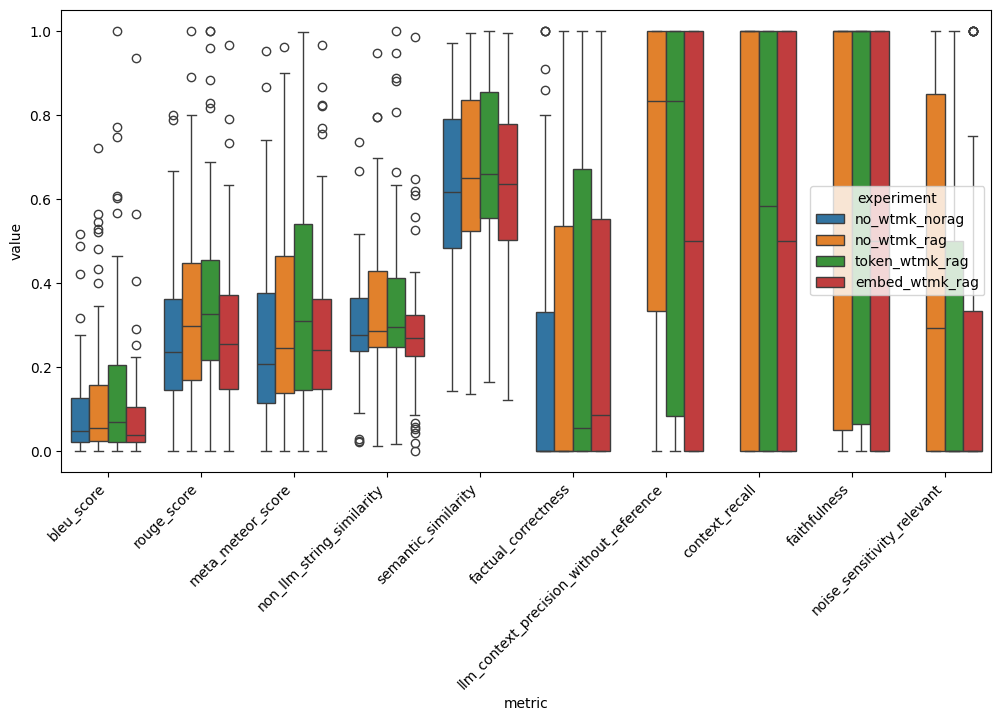

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

df_full = pd.concat(
    [v.to_pandas().assign(experiment=k) for k, v in eval_results.items()], axis=0
)

# df_concat = pd.DataFrame(
#     columns=eval_results["no_wtmk_norag"].to_pandas().columns + ["experiment"]
# )
# for k, v in eval_results.items():
#     df = v.to_pandas().assign(experiment=k)
#     df_concat = pd.concat([df_concat, df])

# df

# # sns.boxplot(data=df_concat, hue="experiment")

df_full = df_full.drop(
    columns=["user_input", "response", "reference", "retrieved_contexts"]
)
df_full = df_full.melt(id_vars=["experiment"], var_name="metric", value_name="value")

plt.xticks(rotation=45, ha="right")
sns.boxplot(data=df_full, x="metric", y="value", hue="experiment")